# Description
The goal of the notebook is to validate detected home and work locations and asses representativeness of their distributions with official data

In [1]:
import pandas as pd
from geofunctions import utils
import geopandas as gpd
import os


In [3]:
df = gpd.read_file("../data/to_map/geohash_work_home_stat_monthly.geojson")

In [4]:
df.head()

,geohash,num_homes,num_works,type,month,flag_good_month,geometry
0,swnt70p,0,1,Work,201901,False,"POLYGON ((34.67285 31.78207, 34.67285 31.78345..."
1,swnt72d,0,1,Work,201901,False,"POLYGON ((34.6756 31.78619, 34.6756 31.78757, ..."
2,swnt74z,1,0,Home,201901,False,"POLYGON ((34.68796 31.78207, 34.68796 31.78345..."
3,swnt75n,3,0,Home,201901,False,"POLYGON ((34.68933 31.7807, 34.68933 31.78207,..."
4,swnt75p,1,0,Home,201901,False,"POLYGON ((34.68933 31.78207, 34.68933 31.78345..."


# Validate home locations

## 1st Approach. Compare to census population

### Aggregate number of home locations by stat area 

In [5]:
gdf_census_gush = gpd.read_file(
    utils.get_path("processed", "adm", "geohash_stat_area_pairs.geojson")
)

In [ ]:
gdf_census_gush.head(2)

,geohash,index_right,OBJECTID,SHEM_YISHUV_HEB,SHEM_YISHUV_ENG,SEMEL_YISHUV,YISHUV_STAT_2022,STAT_2022,Stat2022_Unite,Stat2022_Ref,Main_Function_Code,Main_Function_Txt,ROVA,TAT_ROVA,geometry
0,swnt5jy,15,119,אשדוד,ASHDOD,70,700622,622.0,622,NaN,1.0,מגורים,6.0,62.0,"POLYGON ((34.66049 31.7807, 34.66049 31.78207,..."
1,swnt5tz,10,76,אשדוד,ASHDOD,70,700142,142.0,142,NaN,1.0,מגורים,1.0,14.0,"POLYGON ((34.66049 31.80405, 34.66049 31.80542..."


In [6]:
full_df_census = df.merge(
    gdf_census_gush[["geohash", "YISHUV_STAT_2022"]], on="geohash"
)

In [10]:
statarea_hl = full_df_census.groupby(["YISHUV_STAT_2022", "month"])[
    ["num_homes"]
].sum()

#### Add census data

In [12]:
census_gushdan = gpd.read_file(
    utils.get_path("processed", "census", "census_gushdan_main_features.geojson")
)

In [ ]:
census_gushdan.columns

Index(['OBJECTID', 'SHEM_YISHUV_HEB', 'SHEM_YISHUV_ENG', 'SEMEL_YISHUV',
       'YISHUV_STAT_2022', 'STAT_2022', 'Stat2022_Unite', 'Stat2022_Ref',
       'Main_Function_Code', 'Main_Function_Txt', 'ROVA', 'TAT_ROVA',
       'Religion_Stat_Code', 'Religion_Stat_Txt', 'pop_approx', 'change_pcnt',
       'pop_density', 'sexRatio', 'inst_pcnt', 'Foreign_pcnt', 'age0_19_pcnt',
       'age20_64_pcnt', 'age65_pcnt', 'DependencyRatio', 'age_median',
       'm_age_median', 'w_age_median', 'married18_34_pcnt',
       'married45_54_pcnt', 'j_isr_pcnt', 'j_abr_pcnt', 'aliya2002_pcnt',
       'aliya2010_pcnt', 'israel_pcnt', 'asia_pcnt', 'africa_pcnt',
       'europe_pcnt', 'america_pcnt', 'shem_eretz1', 'MarriageAge_mdn',
       'm_MarriageAge_mdn', 'w_MarriageAge_mdn', 'ChldBorn_avg', 'koshi5_pcnt',
       'koshi65_pcnt', 'AcadmCert_pcnt', 'WrkY_pcnt', 'Empl_pcnt',
       'SelfEmpl_pcnt', 'HrsWrkWk_avg', 'Wrk_15_17_pcnt', 'WrkOutLoc_pcnt',
       'employeesAnnual_medWage', 'EmployeesWage_decile9U

In [13]:
statarea_full = census_gushdan.merge(statarea_hl.reset_index(), on="YISHUV_STAT_2022")

In [15]:
statarea_full[["pop_approx", "num_homes"]].isnull().mean()

pop_approx    0.136699
num_homes     0.000000
dtype: float64

In [16]:
statarea_full["pop_approx"] = statarea_full["pop_approx"].fillna(0)

## Explore dependencies and potential discrepancies

In [14]:
from sklearn.linear_model import LinearRegression


def reg(df, x, y):
    x = df[x].values.reshape(-1, 1)
    y = df[y].values
    reg = LinearRegression(fit_intercept=True).fit(x, y)
    reg_line = reg.predict(x)
    return reg_line

In [17]:
statarea_full["predicted_pop"] = (
    statarea_full.groupby("month")
    .apply(
        lambda group: pd.Series(
            reg(group, "num_homes", "pop_approx"), index=group.index
        )
    )
    .reset_index(level=0, drop=True)
)

In [18]:
statarea_full["residual"] = statarea_full["pop_approx"] - statarea_full["predicted_pop"]

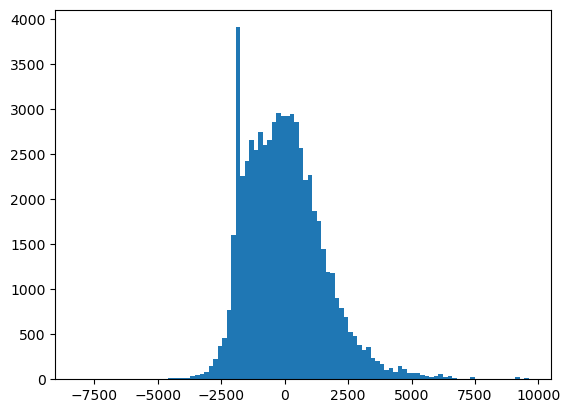

In [22]:
from matplotlib import pyplot as plt


plt.hist(statarea_full["residual"], bins=100);

### Correlation

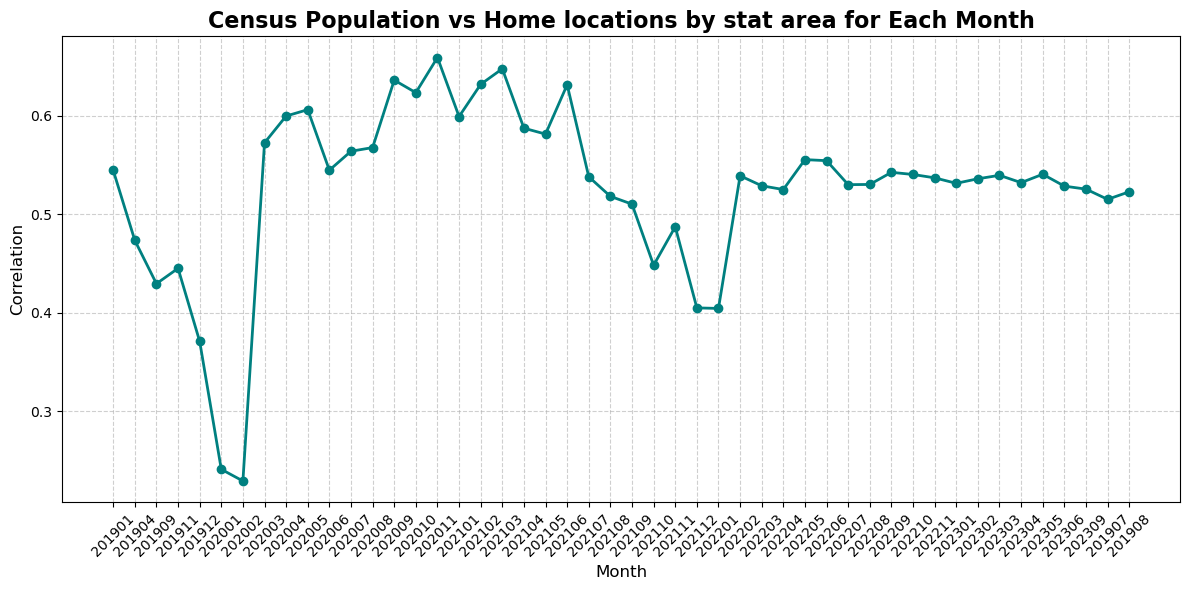

In [32]:
import matplotlib.pyplot as plt

# Extracting the first value of "home_locations" for each month and plotting
statarea_full.groupby("month")[["pop_approx", "num_homes"]].apply(
    lambda group: group[["pop_approx", "num_homes"]].corr().iloc[0, 1]
).plot(figsize=(12, 6), marker="o", linewidth=2, color="teal", legend=False)

# Adding title and labels
plt.title(
    "Census Population vs Home locations by stat area for Each Month",
    fontsize=16,
    fontweight="bold",
)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Correlation", fontsize=12)

# Rotating x-ticks and improving visuals
plt.xticks(range(len(statarea_full.month.unique())),statarea_full.month.unique().tolist(),rotation=45, fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

## Error by type of level of religiosity

In [24]:
statarea_full.groupby(['hh_MidatDatiyut_Name','hh_MidatDatiyut'])["residual"].agg(['mean','std','count'])

,,mean,std,count
hh_MidatDatiyut_Name,hh_MidatDatiyut,,,
דתי/ דתי מאוד,3.0,755.886496,1877.480868,3083
חילוני,1.0,67.166527,1224.754099,42622
חרדי,4.0,2600.850348,1546.250123,2941
מסורתי,2.0,599.065049,1486.554379,6411


## By degree of religiosity

In [34]:
dict_religions = {
    "חילוני": "secular",
    "מסורתי": "traditional",
    "דתי/ דתי מאוד": "religious",
    "חרדי": "haredi",
}
statarea_full["religion_level"] = statarea_full["hh_MidatDatiyut_Name"].map(
    dict_religions
)

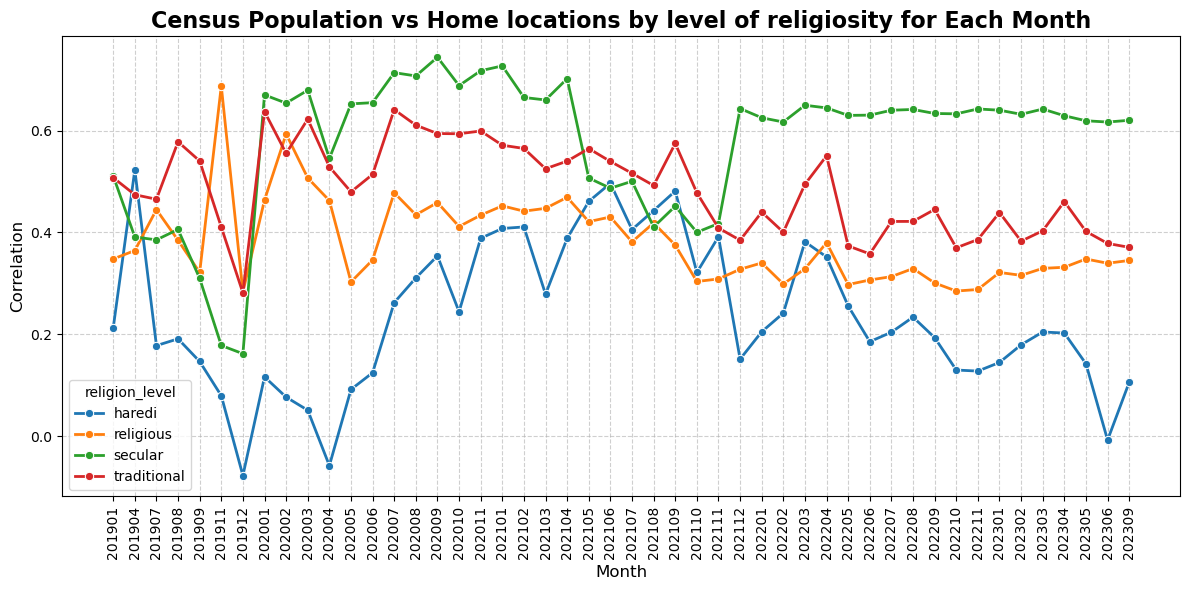

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
# Extracting the first value of "home_locations" for each month and plotting
correlations = (
    statarea_full.groupby(["month", "religion_level"])[
        ["pop_approx", "num_homes"]
    ]
    .apply(lambda group: group[["pop_approx", "num_homes"]].corr().iloc[0, 1])
    .reset_index(name="correlation")
)
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=correlations,
    x="month",
    y="correlation",
    hue="religion_level",
    marker="o",
    linewidth=2,
    color="teal",
    legend=True,
)

# Adding title and labels
plt.title(
    "Census Population vs Home locations by level of religiosity for Each Month",
    fontsize=16,
    fontweight="bold",
)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Correlation", fontsize=12)

# Rotating x-ticks and improving visuals
plt.xticks(rotation=90, fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

## Exclude haredi areas 

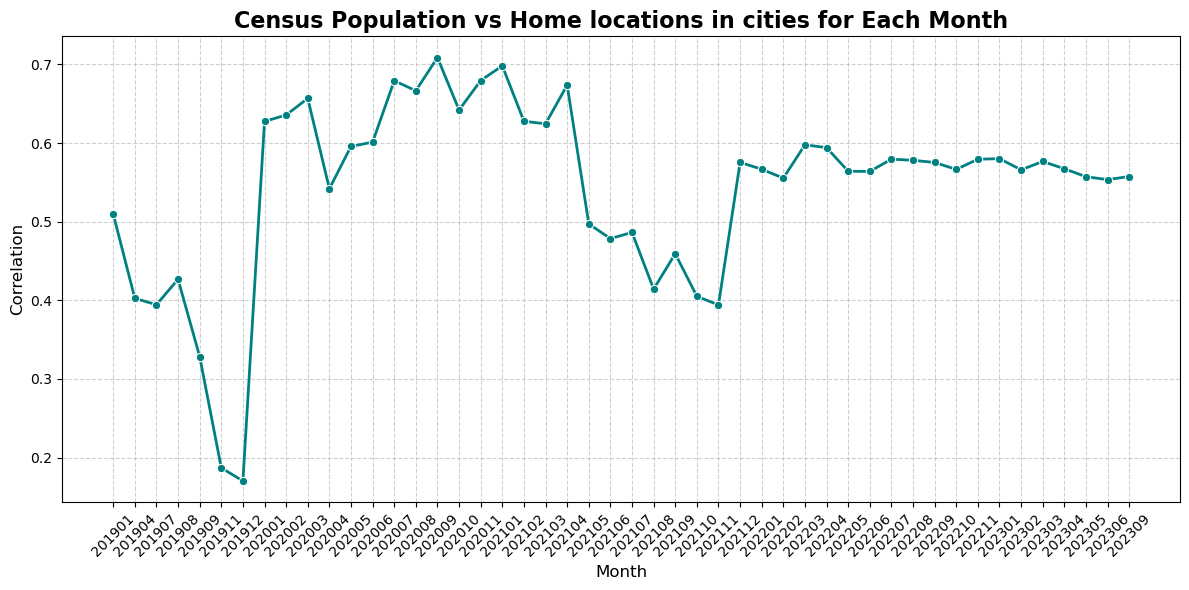

In [42]:
import matplotlib.pyplot as plt

# Extracting the first value of "home_locations" for each month and plotting
correlations = (
     statarea_full[
         statarea_full.religion_level.isin(["secular", "traditional"])
    ]
    .groupby(["month"])[["pop_approx", "num_homes"]]
    .apply(lambda group: group[["pop_approx", "num_homes"]].corr().iloc[0, 1])
    .reset_index(name="correlation")
)
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=correlations,
    x="month",
    y="correlation",
    marker="o",
    linewidth=2,
    color="teal",
    legend=True,
)

# Adding title and labels
plt.title(
    "Census Population vs Home locations in cities for Each Month",
    fontsize=16,
    fontweight="bold",
)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Correlation", fontsize=12)

# Rotating x-ticks and improving visuals
plt.xticks(rotation=45, fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# Further analysis is optional

In [ ]:
 df_homeloc_pop_stat.groupby(["flag_city","religion_level"]).size()/ df_homeloc_pop_stat.groupby(["flag_city"]).size()

flag_city  religion_level
False      haredi            0.004092
           religious         0.077878
           secular           0.692318
           traditional       0.089361
True       haredi            0.037382
           religious         0.040130
           secular           0.717807
           traditional       0.109200
dtype: float64

In [ ]:
df_homeloc_pop_stat["flag_not_religious"] = df_homeloc_pop_stat.religion_level.isin(
    ["secular", "traditional","religious"]
)

In [ ]:
annual_home_pop = (
    df_homeloc_pop_stat[(~df_homeloc_pop_stat.month.isin(["201911", "201909"]))]
    .groupby(["year", "YISHUV_STAT_2022", "flag_city", "flag_not_religious"])[
        ["pop_approx", "home_locations"]
    ]
    .mean()
    .reset_index()
)

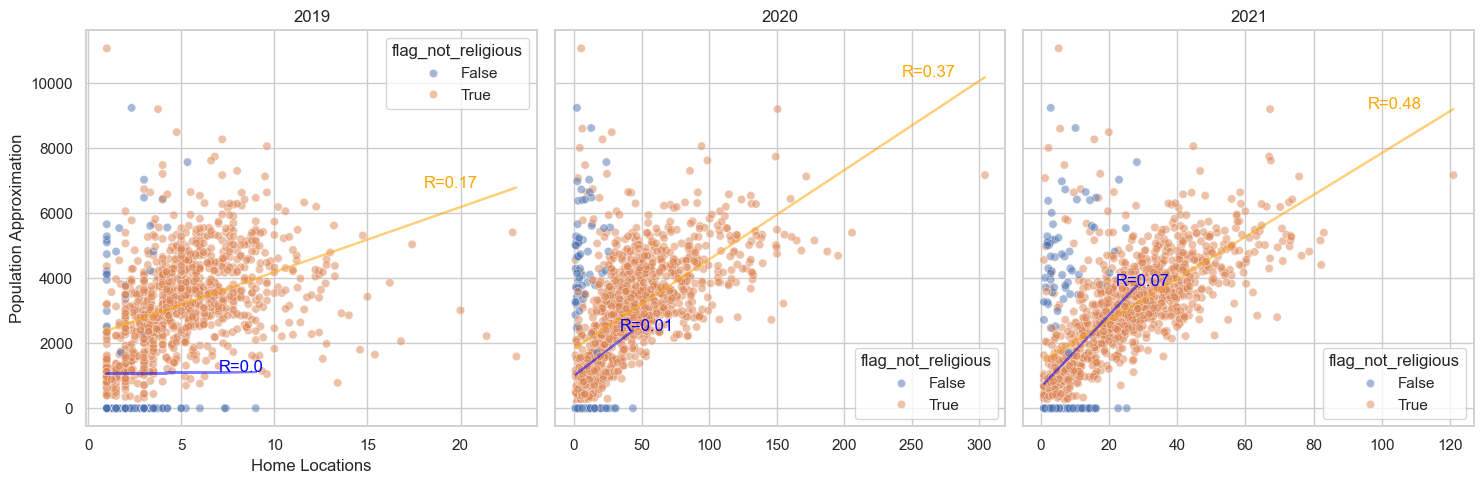

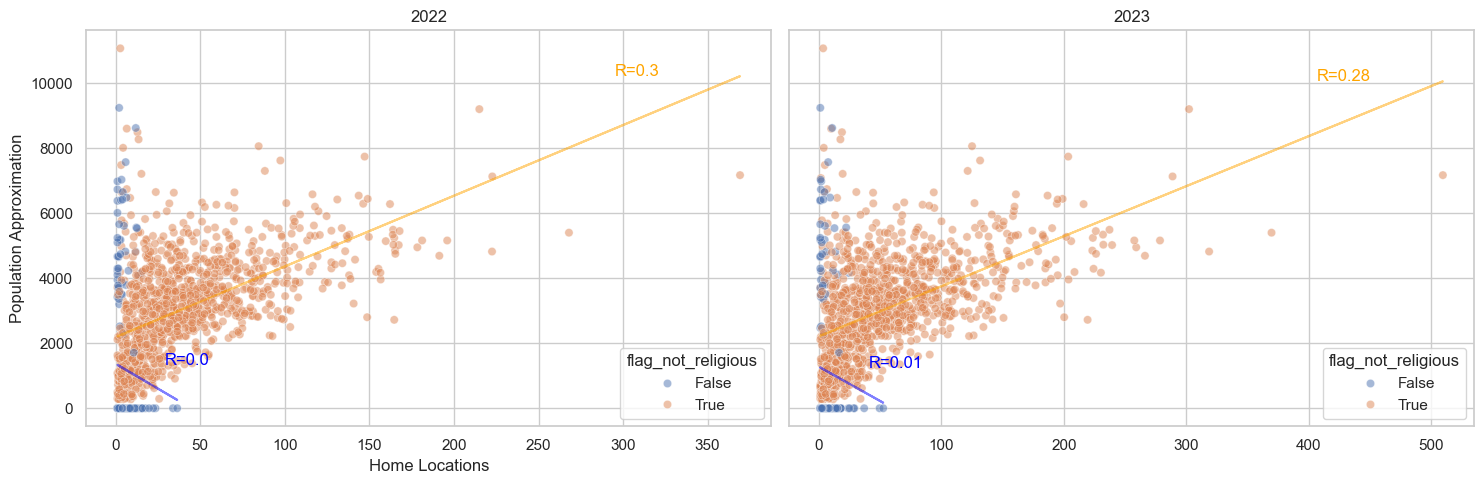

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
import math

# Unique years
years = annual_home_pop.year.unique()

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Plot for each year
for ax, year in zip(axes, years[:3]):

    regline_city = reg(
        annual_home_pop[
            (annual_home_pop.year == year) & (annual_home_pop.flag_not_religious)
        ],
        x="home_locations",
        y="pop_approx",
    )
    regline_not_city = reg(
        annual_home_pop[
            (annual_home_pop.year == year) & (~annual_home_pop.flag_not_religious)
        ],
        x="home_locations",
        y="pop_approx",
    )
    y_city = annual_home_pop[
        (annual_home_pop.year == year) & (annual_home_pop.flag_not_religious)
    ]["pop_approx"].values
    y_not_city = annual_home_pop[
        (annual_home_pop.year == year) & (~annual_home_pop.flag_not_religious)
    ]["pop_approx"].values
    x_city = annual_home_pop[
        (annual_home_pop.year == year) & (annual_home_pop.flag_not_religious)
    ]["home_locations"].values
    x_not_city = annual_home_pop[
        (annual_home_pop.year == year) & (~annual_home_pop.flag_not_religious)
    ]["home_locations"].values
    r2_city = r2_score(y_city, regline_city)
    r2_not_city = r2_score(y_not_city, regline_not_city)
    sns.scatterplot(
        data=annual_home_pop[annual_home_pop.year == year],
        y="pop_approx",
        x="home_locations",
        hue="flag_not_religious",
        ax=ax,
        alpha=0.5,
    )
    ax.set_title(str(year), fontsize=12)
    ax.set_ylabel("Population Approximation")
    ax.set_xlabel(
        "Home Locations" if ax == axes[0] else ""
    )  # Add ylabel only to the first subplot
    # Plot the regression line
    ax.plot(
        annual_home_pop[
            (annual_home_pop.year == year) & (annual_home_pop.flag_not_religious)
        ]["home_locations"],
        regline_city,
        color="orange",
        alpha=0.5,
    )
    ax.text(
        math.floor(max(x_city) * 0.8),
        math.floor(max(regline_city)),
        f"R={round(r2_city,2)}",
        color="orange",
    )
    ax.plot(
        annual_home_pop[
            (annual_home_pop.year == year) & (~annual_home_pop.flag_not_religious)
        ]["home_locations"],
        regline_not_city,
        color="blue",
        alpha=0.5,
    )
    ax.text(
        math.floor(max(x_not_city) * 0.8),
        math.floor(max(regline_not_city)),
        f"R={round(r2_not_city,2)}",
        color="Blue",
    )
# Adjust layout and show
plt.tight_layout()
plt.show()
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

# Plot for each year
for ax, year in zip(axes, years[3:]):
    regline_city = reg(
        annual_home_pop[
            (annual_home_pop.year == year) & (annual_home_pop.flag_not_religious)
        ],
        x="home_locations",
        y="pop_approx",
    )
    regline_not_city = reg(
        annual_home_pop[
            (annual_home_pop.year == year) & (~annual_home_pop.flag_not_religious)
        ],
        x="home_locations",
        y="pop_approx",
    )
    y_city = annual_home_pop[
        (annual_home_pop.year == year) & (annual_home_pop.flag_not_religious)
    ]["pop_approx"].values
    y_not_city = annual_home_pop[
        (annual_home_pop.year == year) & (~annual_home_pop.flag_not_religious)
    ]["pop_approx"].values
    x_city = annual_home_pop[
        (annual_home_pop.year == year) & (annual_home_pop.flag_not_religious)
    ]["home_locations"].values
    x_not_city = annual_home_pop[
        (annual_home_pop.year == year) & (~annual_home_pop.flag_not_religious)
    ]["home_locations"].values
    r2_city = r2_score(y_city, regline_city)
    r2_not_city = r2_score(y_not_city, regline_not_city)
    sns.scatterplot(
        data=annual_home_pop[annual_home_pop.year == year],
        y="pop_approx",
        x="home_locations",
        hue="flag_not_religious",
        ax=ax,
        alpha=0.5,
    )
    ax.set_title(str(year), fontsize=12)
    ax.set_ylabel("Population Approximation")
    ax.set_xlabel(
        "Home Locations" if ax == axes[0] else ""
    )  # Add ylabel only to the first subplot
    ax.plot(
        annual_home_pop[
            (annual_home_pop.year == year) & (annual_home_pop.flag_not_religious)
        ]["home_locations"],
        regline_city,
        color="orange",
        alpha=0.5,
    )
    ax.plot(
        annual_home_pop[
            (annual_home_pop.year == year) & (~annual_home_pop.flag_not_religious)
        ]["home_locations"],
        regline_not_city,
        color="blue",
        alpha=0.5,
    )
    ax.text(
        math.floor(max(x_city) * 0.8),
        math.floor(max(regline_city)),
        f"R={round(r2_city,2)}",
        color="orange",
    )
    ax.text(
        math.floor(max(x_not_city) * 0.8),
        math.floor(max(regline_not_city)),
        f"R={round(r2_not_city,2)}",
        color="Blue",
    )
# Adjust layout and show
plt.tight_layout()
plt.show()

### Analyse home representetiveness by location type and population groups

In [ ]:

df_home_users_geohashes_adm = df_home_users_geohashes.merge(
    df_geohash_city[["geohash", "SHEM_YISHUV_ENG", "YISHUV_STAT_2022", "SEMEL_YISHUV"]],
    on="geohash",
)

In [ ]:
import gc

gc.collect()

447

In [ ]:
df_home_users_geohashes_adm.head()

,identifier,geohash,night_hours_count,nights_count,rank_night,shabbat_hours_counts,rank_shabbat,weight,rank_weighted,hour_work_home,...,share_work_in_home_hours,share_home_work_hours,share_work_in_home_days,share_home_work_days,share_home_hours_home,flag_frequent_user,month,SHEM_YISHUV_ENG,YISHUV_STAT_2022,SEMEL_YISHUV
0,0027d451-3650-490d-ac32-3974fd3bdf65,swnvbdq,4.0,3.0,1.0,1.0,1.0,5.0,1.0,4.0,...,0.166667,0.666667,0.250000,0.500000,0.208333,False,201901,HOLON,66000631,6600
1,003b6189-ca3d-46e8-91aa-f9c271a8826e,swntvne,11.0,7.0,1.0,6.0,1.0,17.0,1.0,4.0,...,0.117647,0.285714,0.200000,0.285714,0.500000,True,201901,GIV'AT BRENNER,1470001,147
2,0051f3fc-32d7-4686-ac58-214c62d6efd5,swnyb4m,0.0,0.0,0.0,1.0,1.0,1.0,1.0,14.0,...,0.666667,0.218750,1.333333,0.200000,0.047619,True,201901,SHOHAM,13040004,1304
3,0052e839-ea74-4c11-9c4a-2527e12126ff,swnys0r,61.0,17.0,1.0,26.0,1.0,87.0,1.0,37.0,...,0.262411,0.637931,1.066667,0.941176,0.617021,True,201901,KEFAR SAVA,69000321,6900
4,00596205-d7d0-4067-ae1b-dbe358625f14,swny1ss,10.0,5.0,1.0,5.0,1.0,15.0,1.0,15.0,...,0.333333,0.254237,1.571429,0.611111,0.333333,True,201901,RAMAT GAN,86000314,8600


In [ ]:
df_stat_area_city = df_geohash_city.drop_duplicates(
    ["YISHUV_STAT_2022", "SEMEL_YISHUV"]
)

In [25]:
census_gushdan.flag_city.value_counts()

AttributeError: 'GeoDataFrame' object has no attribute 'flag_city'

In [ ]:
df_city = df_geohash_city.drop_duplicates(["SEMEL_YISHUV"])

In [ ]:
df_city.flag_city.value_counts()

flag_city
False    254
True      54
Name: count, dtype: int64

In [ ]:
df_city[~df_city.flag_city]

,geohash,YISHUV_STAT_2022,flag_city,SHEM_YISHUV_HEB,SHEM_YISHUV_ENG,SEMEL_YISHUV,Main_Function_Txt,ROVA,TAT_ROVA,Religion_Stat_Code,Religion_Stat_Txt,pop_approx,age20_64_pcnt,pop_city,flag_big_city,hh_MidatDatiyut_Name,SelfEmpl_pcnt,WrkOutLoc_pcnt
0,swnvbff,220001,False,מקווה ישראל,MIQWE YISRA'EL,22,מוסדי,NaN,NaN,NaN,NaN,NaN,NaN,0.0,False,NaN,NaN,NaN
113,swnwtbv,640001,False,"יד רמב""ם",YAD RAMBAM,64,מגורים,NaN,NaN,1.0,יהודים,1300.0,55.3,1300.0,False,מסורתי,18.9,83.0
141,NaN,880001,False,כרם בן שמן,KEREM BEN SHEMEN,88,מגורים,NaN,NaN,1.0,יהודים,120.0,39.9,120.0,False,חילוני,22.4,78.3
142,swny7zu,980001,False,"כפר מל""ל",KEFAR MALAL,98,מגורים,NaN,NaN,1.0,יהודים,350.0,55.6,350.0,False,חילוני,29.7,78.7
156,swpn2u5,1150001,False,חופית,HOFIT,115,מגורים,NaN,NaN,1.0,יהודים,910.0,54.5,910.0,False,חילוני,29.6,72.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15903,swntx58,9965,False,שטח ללא שיפוט,NaN,9965,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,False,NaN,NaN,NaN
15906,swny301,9969,False,שטח ללא שיפוט,NaN,9969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,False,NaN,NaN,NaN
15932,swnvbyt,9970,False,שטח ללא שיפוט,NaN,9970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,False,NaN,NaN,NaN
15937,NaN,37960001,False,כפר האורנים,KEFAR HAORANIM,3796,מגורים,NaN,NaN,1.0,יהודים,2390.0,61.1,2390.0,False,חילוני,18.9,81.7


## In stat area scale

## In city scale

In [ ]:
df_homeloc_pop_cities = (
    df_home_users_geohashes_adm.groupby(["SEMEL_YISHUV", "month"])
    .size()
    .rename("home_locations")
    .reset_index()
    .merge(
        df_city[["pop_city", "flag_big_city", "flag_city", "SEMEL_YISHUV"]],
        on="SEMEL_YISHUV",
    )
)

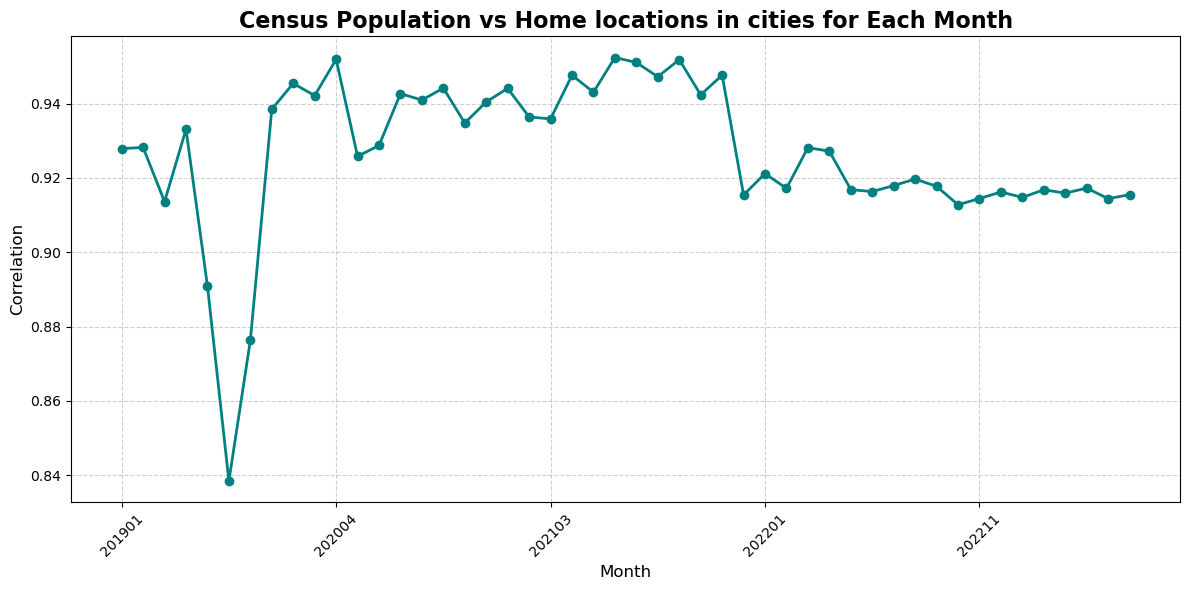

In [ ]:
import matplotlib.pyplot as plt

# Extracting the first value of "home_locations" for each month and plotting
df_homeloc_pop_cities.groupby("month")[["pop_city", "home_locations"]].apply(
    lambda group: group[["pop_city", "home_locations"]].corr().iloc[0, 1]
).plot(figsize=(12, 6), marker="o", linewidth=2, color="teal", legend=False)

# Adding title and labels
plt.title(
    "Census Population vs Home locations in cities for Each Month",
    fontsize=16,
    fontweight="bold",
)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Correlation", fontsize=12)

# Rotating x-ticks and improving visuals
plt.xticks(rotation=45, fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

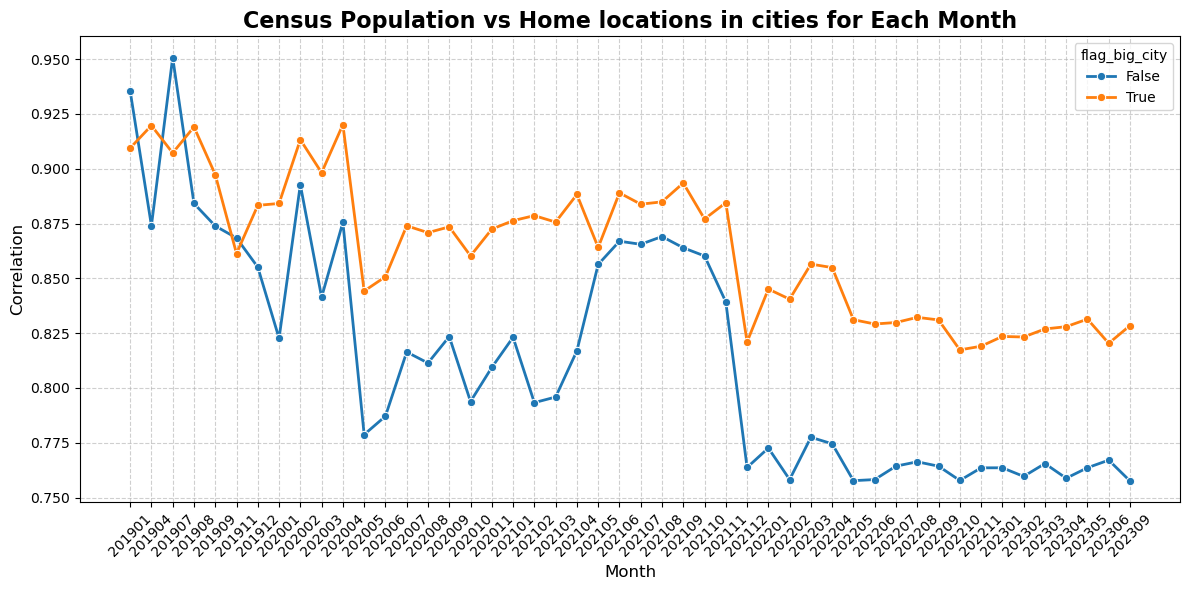

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extracting the first value of "home_locations" for each month and plotting
correlations = (
    df_homeloc_pop_cities.groupby(["month", "flag_big_city"])[
        ["pop_city", "home_locations"]
    ]
    .apply(lambda group: group[["pop_city", "home_locations"]].corr().iloc[0, 1])
    .reset_index(name="correlation")
)
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=correlations,
    x="month",
    y="correlation",
    hue="flag_big_city",
    marker="o",
    linewidth=2,
    color="teal",
    legend=True,
)

# Adding title and labels
plt.title(
    "Census Population vs Home locations in cities for Each Month",
    fontsize=16,
    fontweight="bold",
)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Correlation", fontsize=12)

# Rotating x-ticks and improving visuals
plt.xticks(rotation=45, fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

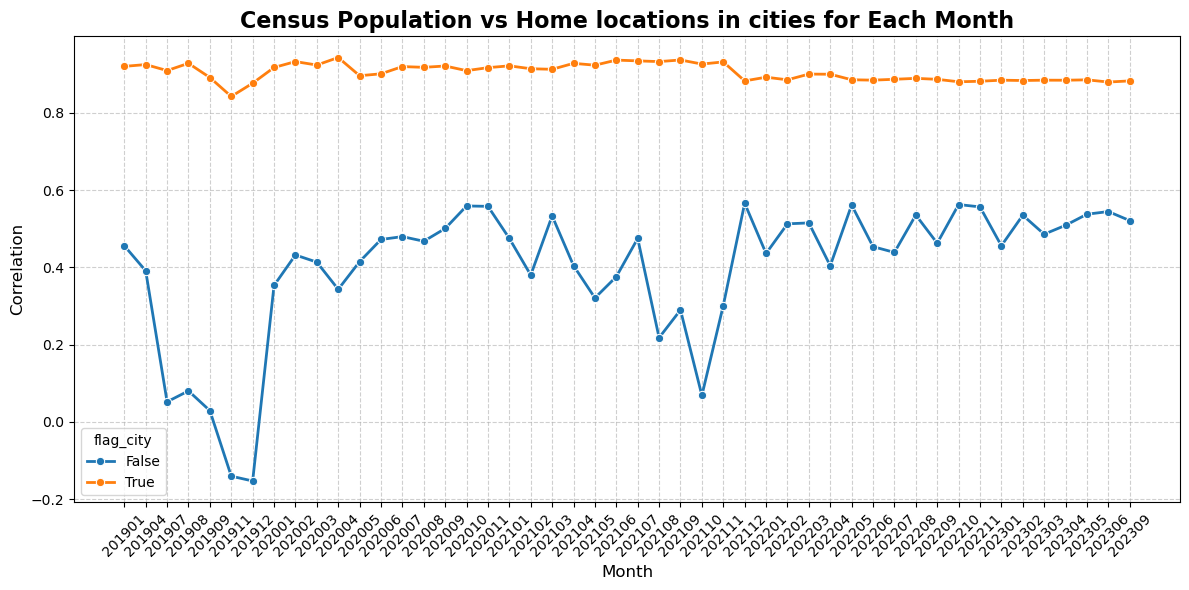

In [ ]:
import matplotlib.pyplot as plt

# Extracting the first value of "home_locations" for each month and plotting
correlations = (
    df_homeloc_pop_cities.groupby(["month", "flag_city"])[
        ["pop_city", "home_locations"]
    ]
    .apply(lambda group: group[["pop_city", "home_locations"]].corr().iloc[0, 1])
    .reset_index(name="correlation")
)
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=correlations,
    x="month",
    y="correlation",
    hue="flag_city",
    marker="o",
    linewidth=2,
    color="teal",
    legend=True,
)

# Adding title and labels
plt.title(
    "Census Population vs Home locations in cities for Each Month",
    fontsize=16,
    fontweight="bold",
)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Correlation", fontsize=12)

# Rotating x-ticks and improving visuals
plt.xticks(rotation=45, fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
df_stat_area_city.head(2)

,geohash,YISHUV_STAT_2022,SHEM_YISHUV_HEB,SHEM_YISHUV_ENG,SEMEL_YISHUV,Main_Function_Txt,ROVA,TAT_ROVA,Religion_Stat_Code,Religion_Stat_Txt,pop_approx,age20_64_pcnt,pop_city,flag_big_city,hh_MidatDatiyut_Name,SelfEmpl_pcnt,WrkOutLoc_pcnt
0,swnvbff,220001,מקווה ישראל,MIQWE YISRA'EL,22,מוסדי,NaN,NaN,NaN,NaN,NaN,NaN,0.0,False,NaN,NaN,NaN
11,swnwhtx,280001,מזכרת בתיה,MAZKERET BATYA,28,מגורים,NaN,NaN,1.0,יהודים,3570.0,55.0,15850.0,False,חילוני,13.6,79.4


In [ ]:
df_stat_area_city["pop_approx"] = df_stat_area_city["pop_approx"].fillna(0)

In [ ]:
df_stat_area_city["hh_MidatDatiyut_Name"].value_counts()

hh_MidatDatiyut_Name
חילוני           950
מסורתי           140
חרדי              78
דתי/ דתי מאוד     73
Name: count, dtype: int64

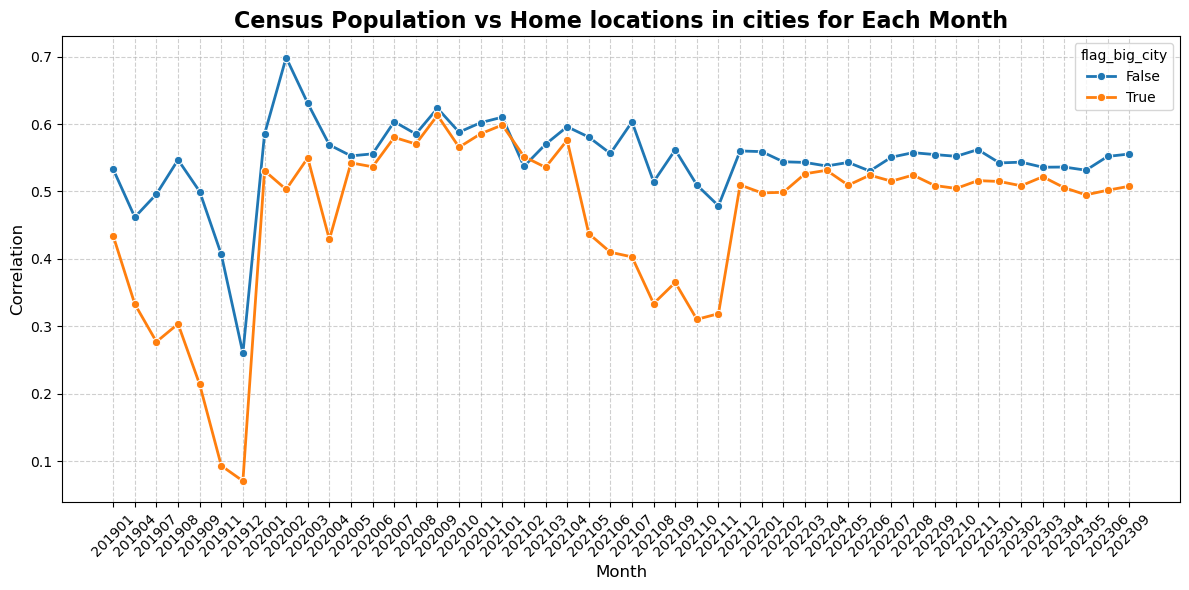

In [ ]:
import matplotlib.pyplot as plt

# Extracting the first value of "home_locations" for each month and plotting
correlations = (
    df_homeloc_pop_stat.groupby(["month", "flag_big_city"])[
        ["pop_approx", "home_locations"]
    ]
    .apply(lambda group: group[["pop_approx", "home_locations"]].corr().iloc[0, 1])
    .reset_index(name="correlation")
)
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=correlations,
    x="month",
    y="correlation",
    hue="flag_big_city",
    marker="o",
    linewidth=2,
    color="teal",
    legend=True,
)

# Adding title and labels
plt.title(
    "Census Population vs Home locations in cities for Each Month",
    fontsize=16,
    fontweight="bold",
)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Correlation", fontsize=12)

# Rotating x-ticks and improving visuals
plt.xticks(rotation=45, fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

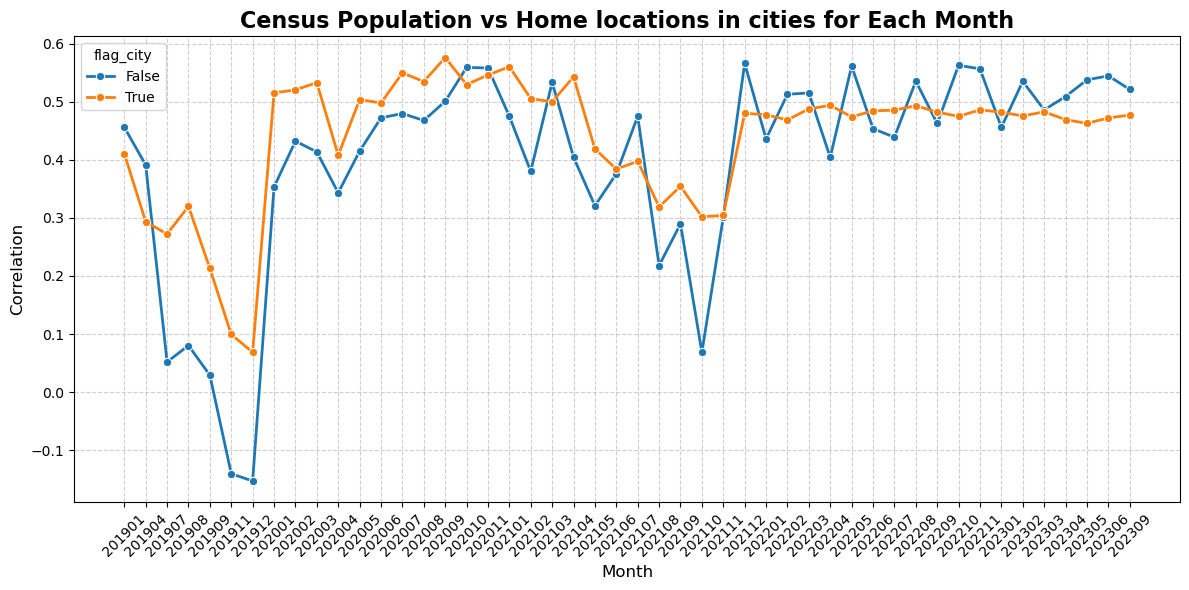

In [ ]:
import matplotlib.pyplot as plt

# Extracting the first value of "home_locations" for each month and plotting
correlations = (
    df_homeloc_pop_stat.groupby(["month", "flag_city"])[
        ["pop_approx", "home_locations"]
    ]
    .apply(lambda group: group[["pop_approx", "home_locations"]].corr().iloc[0, 1])
    .reset_index(name="correlation")
)
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=correlations,
    x="month",
    y="correlation",
    hue="flag_city",
    marker="o",
    linewidth=2,
    color="teal",
    legend=True,
)

# Adding title and labels
plt.title(
    "Census Population vs Home locations in cities for Each Month",
    fontsize=16,
    fontweight="bold",
)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Correlation", fontsize=12)

# Rotating x-ticks and improving visuals
plt.xticks(rotation=45, fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
df_homeloc_pop_stat["year"] = df_homeloc_pop_stat["month"].apply(lambda r: r[:4])

In [ ]:
annual_home_pop = (
    df_homeloc_pop_stat[(~df_homeloc_pop_stat.month.isin(["201911", "201909"]))]
    .groupby(["year", "YISHUV_STAT_2022", "flag_city"])[
        ["pop_approx", "home_locations"]
    ]
    .mean()
    .reset_index()
)

In [ ]:
from sklearn.linear_model import LinearRegression


def reg(df, x, y):
    y = df[y].values
    x = df[x].values.reshape(-1, 1)
    reg = LinearRegression(fit_intercept=True).fit(x, y)
    reg_line = reg.predict(x)
    return reg_line

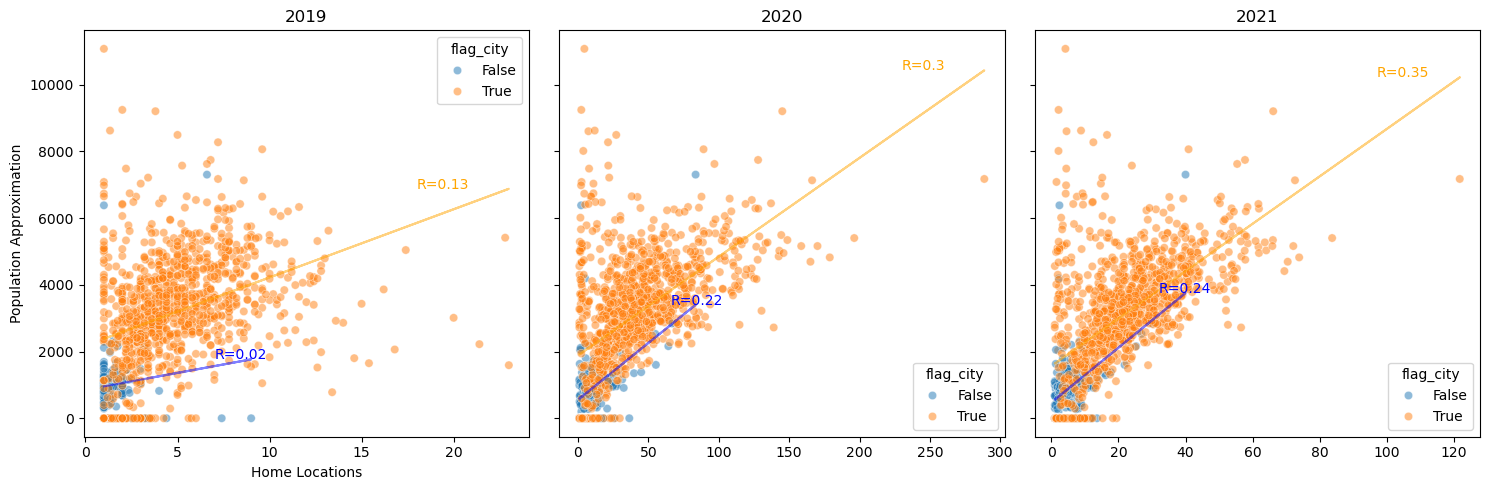

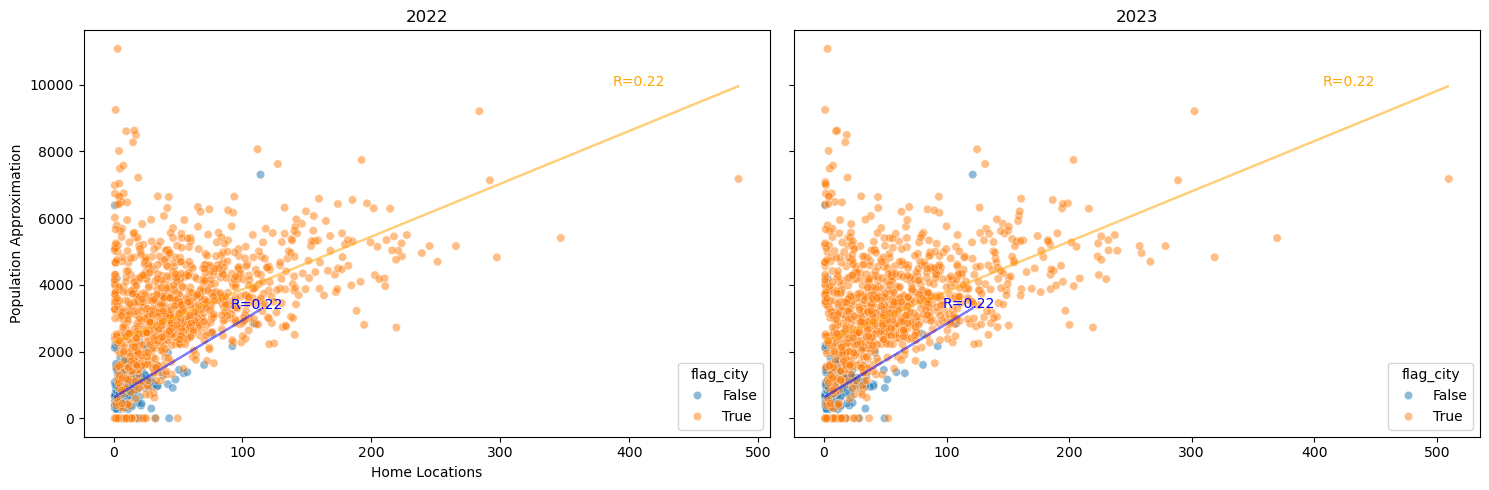

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
import math

# Unique years
years = annual_home_pop.year.unique()

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Plot for each year
for ax, year in zip(axes, years[:3]):

    regline_city = reg(
        annual_home_pop[(annual_home_pop.year == year) & (annual_home_pop.flag_city)],
        x="home_locations",
        y="pop_approx",
    )
    regline_not_city = reg(
        annual_home_pop[(annual_home_pop.year == year) & (~annual_home_pop.flag_city)],
        x="home_locations",
        y="pop_approx",
    )
    y_city = annual_home_pop[
        (annual_home_pop.year == year) & (annual_home_pop.flag_city)
    ]["pop_approx"].values
    y_not_city = annual_home_pop[
        (annual_home_pop.year == year) & (~annual_home_pop.flag_city)
    ]["pop_approx"].values
    x_city = annual_home_pop[
        (annual_home_pop.year == year) & (annual_home_pop.flag_city)
    ]["home_locations"].values
    x_not_city = annual_home_pop[
        (annual_home_pop.year == year) & (~annual_home_pop.flag_city)
    ]["home_locations"].values
    r2_city = r2_score(y_city, regline_city)
    r2_not_city = r2_score(y_not_city, regline_not_city)
    sns.scatterplot(
        data=annual_home_pop[annual_home_pop.year == year],
        y="pop_approx",
        x="home_locations",
        hue="flag_city",
        ax=ax,
        alpha=0.5,
    )
    ax.set_title(str(year), fontsize=12)
    ax.set_ylabel("Population Approximation")
    ax.set_xlabel(
        "Home Locations" if ax == axes[0] else ""
    )  # Add ylabel only to the first subplot
    # Plot the regression line
    ax.plot(
        annual_home_pop[(annual_home_pop.year == year) & (annual_home_pop.flag_city)][
            "home_locations"
        ],
        regline_city,
        color="orange",
        alpha=0.5,
    )
    ax.text(
        math.floor(max(x_city) * 0.8),
        math.floor(max(regline_city)),
        f"R={round(r2_city,2)}",
        color="orange",
    )
    ax.plot(
        annual_home_pop[(annual_home_pop.year == year) & (~annual_home_pop.flag_city)][
            "home_locations"
        ],
        regline_not_city,
        color="blue",
        alpha=0.5,
    )
    ax.text(
        math.floor(max(x_not_city) * 0.8),
        math.floor(max(regline_not_city)),
        f"R={round(r2_not_city,2)}",
        color="Blue",
    )
# Adjust layout and show
plt.tight_layout()
plt.show()
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

# Plot for each year
for ax, year in zip(axes, years[3:]):
    regline_city = reg(
        annual_home_pop[(annual_home_pop.year == year) & (annual_home_pop.flag_city)],
        x="home_locations",
        y="pop_approx",
    )
    regline_not_city = reg(
        annual_home_pop[(annual_home_pop.year == year) & (~annual_home_pop.flag_city)],
        x="home_locations",
        y="pop_approx",
    )
    y_city = annual_home_pop[
        (annual_home_pop.year == year) & (annual_home_pop.flag_city)
    ]["pop_approx"].values
    y_not_city = annual_home_pop[
        (annual_home_pop.year == year) & (~annual_home_pop.flag_city)
    ]["pop_approx"].values
    x_city = annual_home_pop[
        (annual_home_pop.year == year) & (annual_home_pop.flag_city)
    ]["home_locations"].values
    x_not_city = annual_home_pop[
        (annual_home_pop.year == year) & (~annual_home_pop.flag_city)
    ]["home_locations"].values
    r2_city = r2_score(y_city, regline_city)
    r2_not_city = r2_score(y_not_city, regline_not_city)
    sns.scatterplot(
        data=annual_home_pop[annual_home_pop.year == year],
        y="pop_approx",
        x="home_locations",
        hue="flag_city",
        ax=ax,
        alpha=0.5,
    )
    ax.set_title(str(year), fontsize=12)
    ax.set_ylabel("Population Approximation")
    ax.set_xlabel(
        "Home Locations" if ax == axes[0] else ""
    )  # Add ylabel only to the first subplot
    ax.plot(
        annual_home_pop[(annual_home_pop.year == year) & (annual_home_pop.flag_city)][
            "home_locations"
        ],
        regline_city,
        color="orange",
        alpha=0.5,
    )
    ax.plot(
        annual_home_pop[(annual_home_pop.year == year) & (~annual_home_pop.flag_city)][
            "home_locations"
        ],
        regline_not_city,
        color="blue",
        alpha=0.5,
    )
    ax.text(
        math.floor(max(x_city) * 0.8),
        math.floor(max(regline_city)),
        f"R={round(r2_city,2)}",
        color="orange",
    )
    ax.text(
        math.floor(max(x_not_city) * 0.8),
        math.floor(max(regline_not_city)),
        f"R={round(r2_not_city,2)}",
        color="Blue",
    )
# Adjust layout and show
plt.tight_layout()
plt.show()

In [ ]:
(
    df_homeloc_pop_stat[(~df_homeloc_pop_stat.month.isin(["201911", "201909"]))]
    .groupby(["year", "month", "flag_city"])[["pop_approx", "home_locations"]]
    .apply(lambda group: group[["pop_approx", "home_locations"]].corr().iloc[0, 1])
    .groupby(level=[0, 2])
    .mean()
    .reset_index(name="correlation")
)

,year,flag_city,correlation
0,2019,False,0.165281
1,2019,True,0.272921
2,2020,False,0.454062
3,2020,True,0.519455
4,2021,False,0.367364
5,2021,True,0.422391
6,2022,False,0.494538
7,2022,True,0.482524
8,2023,False,0.512788
9,2023,True,0.474469


## Calculate model residuals

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Function to calculate normalized RMSE for each neighborhood after building a model for the whole month
def calculate_rmse_by_neighborhood(group):
    # Fit regression model for the entire month
    y_month = group["pop_approx"].values # Target
    X_month = group["home_locations"].values.reshape(-1, 1) # Predictor  

    model = LinearRegression()
    model.fit(X_month, y_month)
    y_pred_month = model.predict(X_month)

    # Add predictions to the group for calculating RMSE by neighborhood
    group["y_pred"] = y_pred_month

    group["relative_error"] = abs(group["pop_approx"] - group["y_pred"])


    # Return as a DataFrame for clarity
    return group[["YISHUV_STAT_2022","relative_error","y_pred"]]


# Group by month and calculate RMSE for each neighborhood
results = df_homeloc_pop_stat.groupby("month").apply(calculate_rmse_by_neighborhood)

# Resetting index for cleaner DataFrame
results_df = results.reset_index()

# Group by month and calculate RMSE for each neighborhood
results_hiloni = (
    df_homeloc_pop_stat[df_homeloc_pop_stat.flag_not_religious]
    .groupby("month")
    .apply(calculate_rmse_by_neighborhood)
)

# Resetting index for cleaner DataFrame
results_df_hiloni = results_hiloni.reset_index()

# Display the results
print(results_df)

        month  level_1  YISHUV_STAT_2022  relative_error       y_pred
0      201901        0              5516     2217.059612  2217.059612
1      201901       32              5518     3188.782218  3188.782218
2      201901       93              5520     3188.782218  3188.782218
3      201901      126              5525     2217.059612  2217.059612
4      201901      210              5530     2702.920915  2702.920915
...       ...      ...               ...             ...          ...
36684  202309    36568          97000035      127.371870  3027.371870
36685  202309    36595          97000041     2338.318300  2338.318300
36686  202309    36624          97000042      246.641402  2876.641402
36687  202309    36656          97000043      291.024212  3781.024212
36688  202309    36688          97000044      248.903800  3501.096200

[36689 rows x 5 columns]


In [ ]:
results_df

,month,level_1,YISHUV_STAT_2022,relative_error,y_pred
0,201901,0,5516,2217.059612,2217.059612
1,201901,32,5518,3188.782218,3188.782218
2,201901,93,5520,3188.782218,3188.782218
3,201901,126,5525,2217.059612,2217.059612
4,201901,210,5530,2702.920915,2702.920915
...,...,...,...,...,...
36684,202309,36568,97000035,127.371870,3027.371870
36685,202309,36595,97000041,2338.318300,2338.318300
36686,202309,36624,97000042,246.641402,2876.641402
36687,202309,36656,97000043,291.024212,3781.024212


## Merge all together

In [ ]:
df_homeloc_pop_stat = df_homeloc_pop_stat.drop(['relative_error'], axis=1).merge(
    results_df.drop(["level_1"], axis=1), on=["YISHUV_STAT_2022", "month"], how="left"
)

In [ ]:
df_homeloc_pop_stat = df_homeloc_pop_stat.drop(['relative_error_not_relig_only'], axis=1).merge(
    results_df_hiloni.drop(["level_1"], axis=1),
    on=["YISHUV_STAT_2022", "month"],
    how="left",
    suffixes=("","_not_relig_only")
)

In [ ]:
df_homeloc_pop_stat.head()

,YISHUV_STAT_2022,month,home_locations,pop_approx,flag_big_city,flag_city,SHEM_YISHUV_HEB,SHEM_YISHUV_ENG,hh_MidatDatiyut_Name,religion_level,...,Unnamed: 0,flag_remote_work_min_prob,remote_work_probability,flag_remote_work_comparison,share_remote_work_comparison_days,share_remote_work_min_prob_days,relative_error,y_pred,relative_error_not_relig_only,y_pred_not_relig_only
0,5516,201901,1,0.0,False,False,עמק חפר,Emeq Hefer,NaN,NaN,...,0,0.077778,0.076032,0.088889,0.157576,0.142424,2217.059612,2217.059612,NaN,NaN
1,5516,201904,2,0.0,False,False,עמק חפר,Emeq Hefer,NaN,NaN,...,1,0.034759,0.021687,0.015152,0.023810,0.051587,2854.346461,2854.346461,NaN,NaN
2,5516,201907,8,0.0,False,False,עמק חפר,Emeq Hefer,NaN,NaN,...,2,0.248006,0.197501,0.241295,0.369048,0.361310,3406.381050,3406.381050,NaN,NaN
3,5516,201908,4,0.0,False,False,עמק חפר,Emeq Hefer,NaN,NaN,...,3,0.066667,0.066667,0.066667,0.142857,0.142857,3029.524852,3029.524852,NaN,NaN
4,5516,201909,4,0.0,False,False,עמק חפר,Emeq Hefer,NaN,NaN,...,4,0.065079,0.057143,0.065079,0.092063,0.092063,3137.949037,3137.949037,NaN,NaN


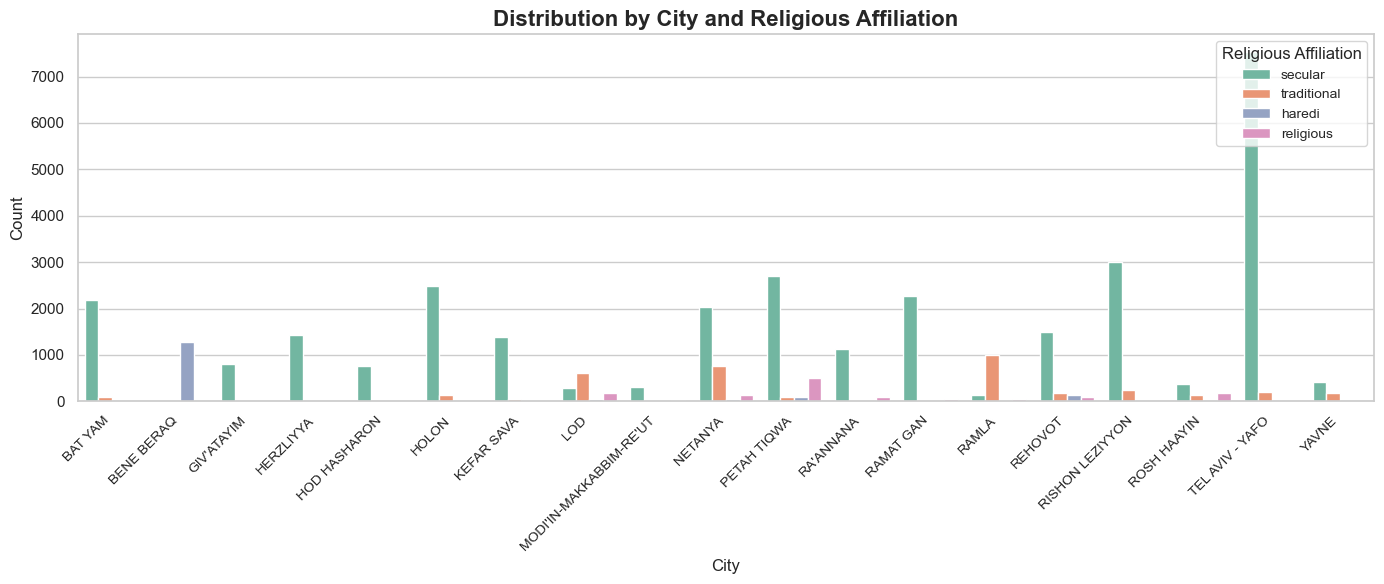

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group the data and reset the index for Seaborn
grouped_data = (
    df_homeloc_pop_stat[df_homeloc_pop_stat["flag_big_city"]]
    .groupby(["SHEM_YISHUV_ENG", "religion_level"])
    .size()
    .reset_index(name="count")
)

# Set the Seaborn style
sns.set(style="whitegrid")

# Create the bar plot
plt.figure(figsize=(14, 6))
sns.barplot(
    data=grouped_data,
    x="SHEM_YISHUV_ENG",
    y="count",
    hue="religion_level",
    palette="Set2",
)

# Add title and labels
plt.title(
    "Distribution by City and Religious Affiliation", fontsize=16, fontweight="bold"
)
plt.xlabel("City", fontsize=12)
plt.ylabel("Count", fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=10, ha="right")

# Adjust the legend
plt.legend(
    title="Religious Affiliation", fontsize=10, title_fontsize=12, loc="upper right"
)

# Adjust layout and display
plt.tight_layout()
plt.show()

Apparently arabs are classified as traditional ( masorati)

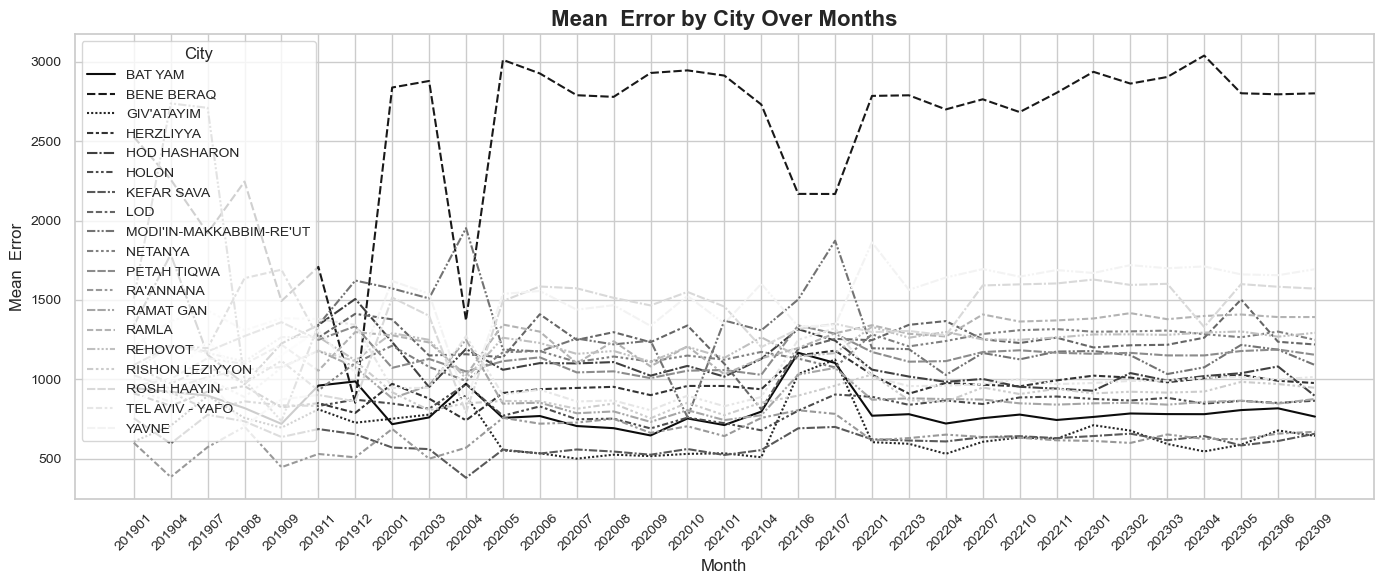

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate mean relative error for big cities
mean_city_error = (
    df_homeloc_pop_stat[df_homeloc_pop_stat["flag_big_city"]]
    .groupby(["SHEM_YISHUV_ENG", "month"])["relative_error"]
    .mean()
    .reset_index()
)

# Set the Seaborn style
sns.set(style="whitegrid")

# Plot with grey colors and different line styles
plt.figure(figsize=(14, 6))
sns.lineplot(
    data=mean_city_error,
    x="month",
    y="relative_error",
    hue="SHEM_YISHUV_ENG",
    palette="gray",  # Use grey color palette
    style="SHEM_YISHUV_ENG",  # Different line styles for cities
    dashes=True,
)

# Customize the title and labels
plt.title("Mean  Error by City Over Months", fontsize=16, fontweight="bold")
plt.xlabel("Month", fontsize=12)
plt.ylabel("Mean  Error", fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)

# Adjust legend
plt.legend(title="City", fontsize=10, title_fontsize=12, loc="upper left")

# Adjust layout and display
plt.tight_layout()
plt.show()

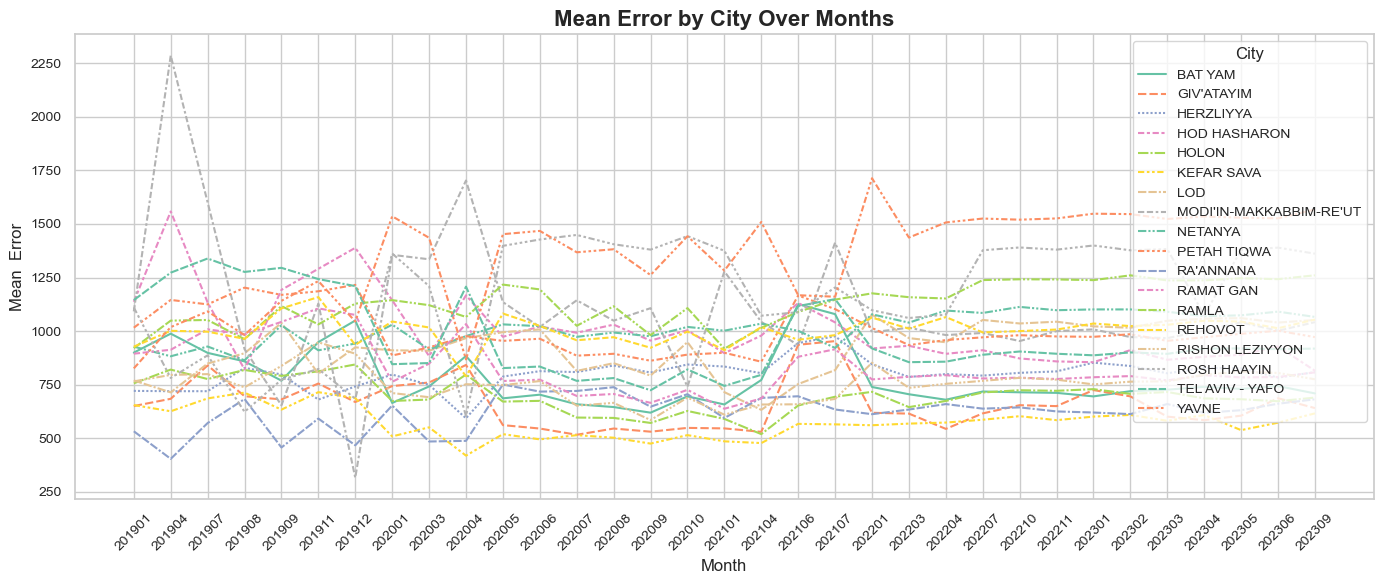

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate mean relative error for big cities
mean_city_error = (
    df_homeloc_pop_stat[
        (df_homeloc_pop_stat["flag_big_city"])
        & (df_homeloc_pop_stat.flag_not_religious)
    ]
    .groupby(["SHEM_YISHUV_ENG", "month"])["relative_error_not_relig_only"]
    .mean()
    .reset_index()
)

# Set the Seaborn style
sns.set(style="whitegrid")

# Plot with grey colors and different line styles
plt.figure(figsize=(14, 6))
sns.lineplot(
    data=mean_city_error,
    x="month",
    y="relative_error_not_relig_only",
    hue="SHEM_YISHUV_ENG",
    palette="Set2",  # Use grey color palette
    style="SHEM_YISHUV_ENG",  # Different line styles for cities
    dashes=True,
)

# Customize the title and labels
plt.title("Mean Error by City Over Months", fontsize=16, fontweight="bold")
plt.xlabel("Month", fontsize=12)
plt.ylabel("Mean  Error", fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)

# Adjust legend
plt.legend(title="City", fontsize=10, title_fontsize=12, loc="upper right")

# Adjust layout and display
plt.tight_layout()
plt.show()

In [ ]:
city_error_avg = df_homeloc_pop_stat[(df_homeloc_pop_stat["flag_big_city"])&(df_homeloc_pop_stat.flag_not_religious)].groupby(
    ["SHEM_YISHUV_ENG", "month"]
)['relative_error_not_relig_only'].mean().groupby("SHEM_YISHUV_ENG").mean()/df_homeloc_pop_stat[(df_homeloc_pop_stat["flag_big_city"])&(df_homeloc_pop_stat.flag_not_religious)].groupby(
    ["SHEM_YISHUV_ENG"])['pop_approx'].mean()
city_error_avg.sort_values()

SHEM_YISHUV_ENG
KEFAR SAVA                 0.170687
GIV'ATAYIM                 0.191172
HOLON                      0.197290
RA'ANNANA                  0.200140
RISHON LEZIYYON            0.201202
HERZLIYYA                  0.224685
RAMAT GAN                  0.242280
HOD HASHARON               0.244745
MODI'IN-MAKKABBIM-RE'UT    0.268076
PETAH TIQWA                0.273305
REHOVOT                    0.275973
NETANYA                    0.281213
LOD                        0.282282
BAT YAM                    0.287088
ROSH HAAYIN                0.308107
TEL AVIV - YAFO            0.314979
YAVNE                      0.324722
RAMLA                      0.353936
dtype: float64

In [ ]:
list_city_fine = city_error_avg[city_error_avg<1.5].index


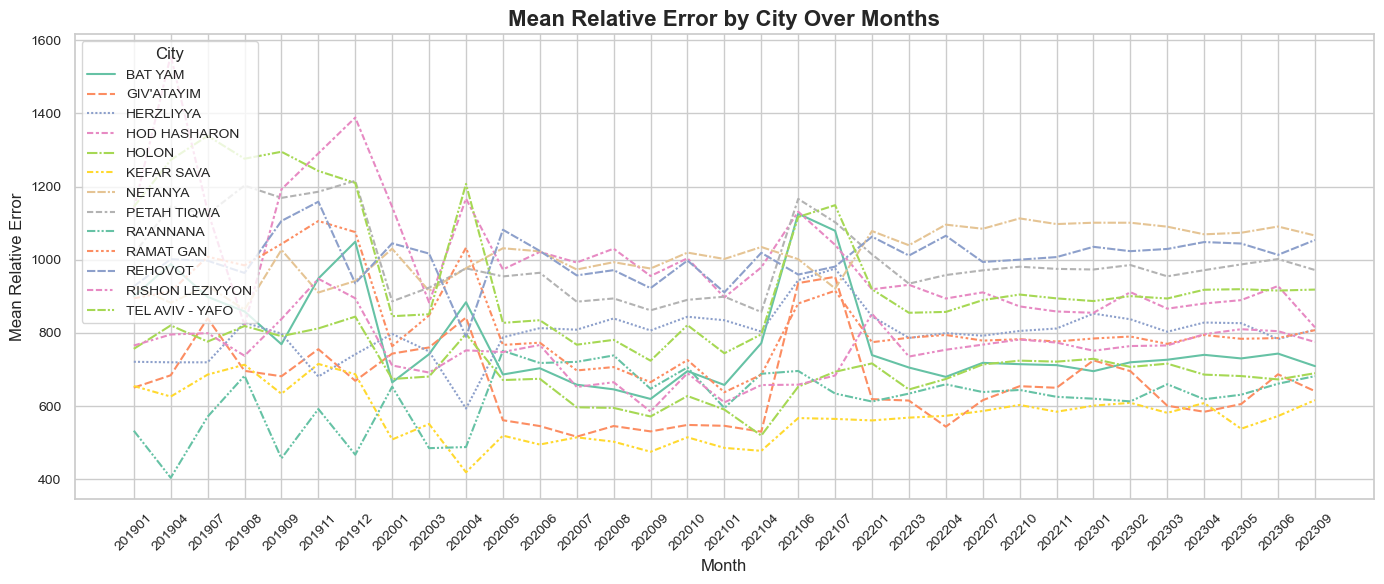

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate mean relative error for big cities
mean_city_error = (
    df_homeloc_pop_stat[
        (df_homeloc_pop_stat["flag_big_city"])
        & (df_homeloc_pop_stat.flag_not_religious)
        & (df_homeloc_pop_stat["SHEM_YISHUV_ENG"].isin(list_city_fine ))
    ]
    .groupby(["SHEM_YISHUV_ENG", "month"])["relative_error_not_relig_only"]
    .mean()
    .reset_index()
)

# Set the Seaborn style
sns.set(style="whitegrid")

# Plot with grey colors and different line styles
plt.figure(figsize=(14, 6))
sns.lineplot(
    data=mean_city_error,
    x="month",
    y="relative_error_not_relig_only",
    hue="SHEM_YISHUV_ENG",
    palette="Set2",  # Use grey color palette
    style="SHEM_YISHUV_ENG",  # Different line styles for cities
    dashes=True,
)

# Customize the title and labels
plt.title("Mean Relative Error by City Over Months", fontsize=16, fontweight="bold")
plt.xlabel("Month", fontsize=12)
plt.ylabel("Mean Relative Error", fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)

# Adjust legend
plt.legend(title="City", fontsize=10, title_fontsize=12, loc="upper left")

# Adjust layout and display
plt.tight_layout()
plt.show()

# 2nd approach. Comparing vs residential buildings